Bibliothèques importées avec succès.
Données d'entraînement, de validation, de test et mappings chargés avec succès.
Train DataFrame shape: (25600162, 6)
Validation DataFrame shape: (3200021, 6)
Test DataFrame shape: (3200021, 6)
Nombre d'utilisateurs mappés : 200948
Nombre de films mappés : 84432

--- Modèle 1 : Filtrage Collaboratif Basé sur la Similarité ---

--- Construction de la matrice utilisateur-film sparse ---
Données d'entraînement, de validation, de test et mappings chargés avec succès.
Train DataFrame shape: (25600162, 6)
Validation DataFrame shape: (3200021, 6)
Test DataFrame shape: (3200021, 6)
Nombre d'utilisateurs mappés : 200948
Nombre de films mappés : 84432

--- Modèle 1 : Filtrage Collaboratif Basé sur la Similarité ---

--- Construction de la matrice utilisateur-film sparse ---
Sparse matrix shape: (200948, 84432)

--- Calcul de la similarité utilisateur (cosinus) ---
User similarity shape: (1000, 1000)

Évaluation du Filtrage Collaboratif Basé sur la Similarité (

C:\Users\khelfa\AppData\Local\Temp\ipykernel_72748\597187821.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='RMSE', data=results, palette='coolwarm')


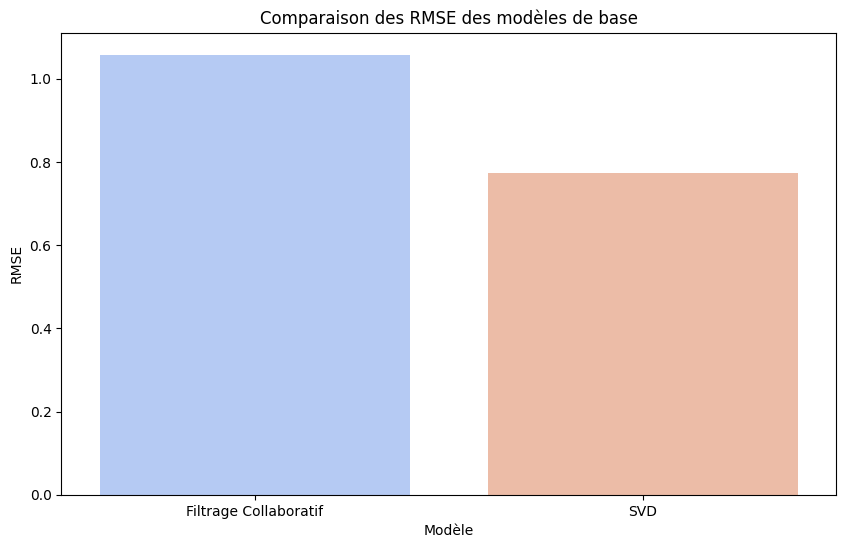

C:\Users\khelfa\AppData\Local\Temp\ipykernel_72748\597187821.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='MAE', data=results, palette='coolwarm')


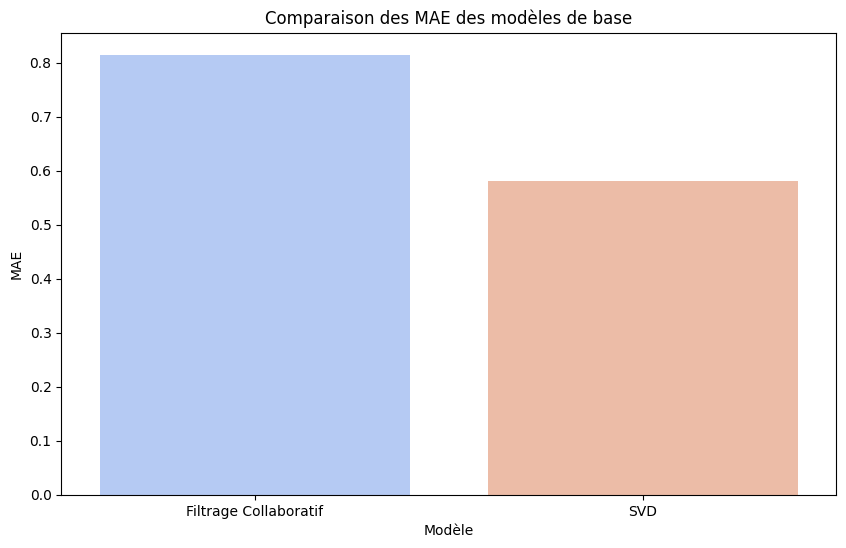


Modèle SVD sauvegardé sous '../data/svd_model.pkl'.

--- Implémentation et évaluation des modèles de base terminées ! ---


In [4]:
# -*- coding: utf-8 -*-
"""
# 2_Baseline_Models.ipynb

Ce notebook implémente et évalue des modèles de recommandation de base :
le filtrage collaboratif (basé sur la similarité) et la factorisation matricielle (SVD).
Ces modèles serviront de points de comparaison pour le modèle de Deep Learning.
"""

# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# Pour le filtrage collaboratif basé sur la similarité
from sklearn.metrics.pairwise import cosine_similarity

# Pour la factorisation matricielle (SVD)
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

print("Bibliothèques importées avec succès.")

# 2. Chargement des données prétraitées et des mappings
try:
    train_df = pd.read_csv('../data/train_ratings.csv')
    val_df = pd.read_csv('../data/val_ratings.csv')
    test_df = pd.read_csv('../data/test_ratings.csv')

    user_to_id = np.load('../data/user_to_id.npy', allow_pickle=True).item()
    id_to_user = np.load('../data/id_to_user.npy', allow_pickle=True).item()
    movie_to_id = np.load('../data/movie_to_id.npy', allow_pickle=True).item()
    id_to_movie = np.load('../data/id_to_movie.npy', allow_pickle=True).item()

    print("Données d'entraînement, de validation, de test et mappings chargés avec succès.")
    print(f"Train DataFrame shape: {train_df.shape}")
    print(f"Validation DataFrame shape: {val_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")

except FileNotFoundError:
    print("Erreur : Les fichiers de données ou de mappings n'ont pas été trouvés.")
    print("Assure-toi d'avoir exécuté le notebook '1_EDA_Preprocessing.ipynb' au préalable.")
    exit()

# Déterminer le nombre total d'utilisateurs et de films mappés
n_users_mapped = len(user_to_id)
n_movies_mapped = len(movie_to_id)
print(f"Nombre d'utilisateurs mappés : {n_users_mapped}")
print(f"Nombre de films mappés : {n_movies_mapped}")

# --- Modèle 1 : Filtrage Collaboratif Basé sur la Similarité (Simple) ---
print("\n--- Modèle 1 : Filtrage Collaboratif Basé sur la Similarité ---")

# Pour une implémentation simple, nous allons créer une matrice utilisateur-film
# à partir de l'ensemble d'entraînement.

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# --- Construction de la matrice utilisateur-film sparse ---
print("\n--- Construction de la matrice utilisateur-film sparse ---")
row = train_df['user_id_mapped'].values
col = train_df['movie_id_mapped'].values
data = train_df['rating'].values

n_users = train_df['user_id_mapped'].max() + 1
n_movies = train_df['movie_id_mapped'].max() + 1

user_movie_sparse = csr_matrix((data, (row, col)), shape=(n_users, n_movies))
print(f"Sparse matrix shape: {user_movie_sparse.shape}")

# --- Calcul de la similarité utilisateur (cosinus) ---
print("\n--- Calcul de la similarité utilisateur (cosinus) ---")
# Pour des raisons de mémoire, limite à un sous-ensemble d'utilisateurs
sample_user_idx = np.random.choice(user_movie_sparse.shape[0], size=1000, replace=False)
user_movie_sample = user_movie_sparse[sample_user_idx]

user_similarity_sparse = cosine_similarity(user_movie_sample)
print(f"User similarity shape: {user_similarity_sparse.shape}")

# --- Nouvelle fonction de prédiction pour sparse matrix ---
def predict_user_based_cf_sparse(user_idx, movie_idx, user_movie_sample, user_similarity_sparse, k=10):
    # user_idx: index dans sample_user_idx
    # movie_idx: index du film
    # user_movie_sample: matrice sparse (échantillon)
    # user_similarity_sparse: matrice de similarité (échantillon)
    # k: nombre de voisins
    if movie_idx >= user_movie_sample.shape[1]:
        return user_movie_sample.data.mean() if user_movie_sample.nnz > 0 else 3.0

    users_rated = user_movie_sample[:, movie_idx].nonzero()[0]
    if len(users_rated) == 0:
        return user_movie_sample.data.mean() if user_movie_sample.nnz > 0 else 3.0

    similarities = user_similarity_sparse[user_idx, users_rated]
    ratings = user_movie_sample[users_rated, movie_idx].toarray().flatten()

    if len(similarities) > k:
        top_k_idx = np.argsort(similarities)[-k:]
        similarities = similarities[top_k_idx]
        ratings = ratings[top_k_idx]

    if similarities.sum() == 0:
        return ratings.mean() if len(ratings) > 0 else 3.0

    return np.dot(similarities, ratings) / np.sum(np.abs(similarities))

# --- Boucle d'évaluation adaptée ---
print("\nÉvaluation du Filtrage Collaboratif Basé sur la Similarité (sparse, sur l'ensemble de test)...")
predictions_cf = []
true_ratings_cf = []

# Limiter l'évaluation aux utilisateurs du sous-échantillon
sample_test_df = test_df[test_df['user_id_mapped'].isin(sample_user_idx)].sample(n=min(len(test_df), 1000), random_state=42)

user_idx_map = {uid: idx for idx, uid in enumerate(sample_user_idx)}

for _, row in sample_test_df.iterrows():
    user_id = row['user_id_mapped']
    movie_id = int(row['movie_id_mapped'])  # <-- Cast to int
    true_rating = row['rating']

    if user_id in user_idx_map:
        user_idx = user_idx_map[user_id]
        predicted_rating = predict_user_based_cf_sparse(user_idx, movie_id, user_movie_sample, user_similarity_sparse)
    else:
        predicted_rating = user_movie_sample.data.mean() if user_movie_sample.nnz > 0 else 3.0

    predictions_cf.append(predicted_rating)
    true_ratings_cf.append(true_rating)

rmse_cf = sqrt(mean_squared_error(true_ratings_cf, predictions_cf))
mae_cf = mean_absolute_error(true_ratings_cf, predictions_cf)

print(f"RMSE (Filtrage Collaboratif) : {rmse_cf:.4f}")
print(f"MAE (Filtrage Collaboratif) : {mae_cf:.4f}")

# --- Modèle 2 : Factorisation Matricielle (SVD) avec Surprise ---
print("\n--- Modèle 2 : Factorisation Matricielle (SVD) avec Surprise ---")

# Charger les données dans le format attendu par Surprise
# Le Reader spécifie la plage des notes
reader = Reader(rating_scale=(1, 5))
#data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

# Diviser les données en entraînement et test pour Surprise
# Surprise a sa propre fonction de split qui est plus adaptée à ses objets Dataset.
# Nous allons utiliser l'ensemble d'entraînement complet pour entraîner le modèle SVD
# et l'évaluer sur l'ensemble de test que nous avons déjà préparé.
# Pour Surprise, il est plus simple de recharger les données et de faire un split interne.
# Ou alors, on peut construire un Dataset à partir de nos train_df et test_df.

# Créer un Dataset Surprise à partir de train_df
trainset = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader).build_full_trainset()

# Créer un testset Surprise à partir de test_df
# Le format de testset pour Surprise est une liste de tuples (userId, movieId, true_rating)
testset = list(test_df.apply(lambda x: (x['userId'], x['movieId'], x['rating']), axis=1))

print(f"Taille du trainset Surprise : {trainset.n_ratings} ratings")
print(f"Taille du testset Surprise : {len(testset)} ratings")

# Entraînement du modèle SVD
# On peut ajuster les paramètres comme n_factors (nombre de facteurs latents), n_epochs, lr_all, reg_all
print("Entraînement du modèle SVD...")
algo_svd = SVD(n_factors=50, n_epochs=20, random_state=42, verbose=True)
algo_svd.fit(trainset)
print("Modèle SVD entraîné avec succès.")

# Évaluation du modèle SVD sur l'ensemble de test
print("\nÉvaluation du modèle SVD (sur l'ensemble de test)...")
predictions_svd = algo_svd.test(testset)

# Calcul des métriques avec Surprise
rmse_svd = accuracy.rmse(predictions_svd, verbose=False)
mae_svd = accuracy.mae(predictions_svd, verbose=False)

print(f"RMSE (SVD) : {rmse_svd:.4f}")
print(f"MAE (SVD) : {mae_svd:.4f}")

# --- Comparaison des Modèles ---
print("\n--- Comparaison des performances des modèles de base ---")
results = pd.DataFrame({
    'Modèle': ['Filtrage Collaboratif', 'SVD'],
    'RMSE': [rmse_cf, rmse_svd],
    'MAE': [mae_cf, mae_svd]
})
print(results)

# Visualisation de la comparaison
plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='RMSE', data=results, palette='coolwarm')
plt.title('Comparaison des RMSE des modèles de base')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='MAE', data=results, palette='coolwarm')
plt.title('Comparaison des MAE des modèles de base')
plt.ylabel('MAE')
plt.show()

# --- Sauvegarde du modèle SVD entraîné ---
from surprise import dump
dump.dump('../data/svd_model.pkl', algo=algo_svd)
print("\nModèle SVD sauvegardé sous '../data/svd_model.pkl'.")

print("\n--- Implémentation et évaluation des modèles de base terminées ! ---")